#### Make Combined LLM Log Likelihood Dataset

In [2]:
from datasets import Dataset, load_dataset
import pandas as pd
from functools import reduce
import os 

def load_log_likelihoods(model_name): 

    paths = [
        f"/scratch/mr7401/log_likelihoods_Truncation_Fixed_BS1/{model_name}/log_likelihood_NEW.jsonl",
        f"/scratch/mr7401/log_likelihoods_Truncation_Fixed_BS1/{model_name}/log_likelihood_2000.jsonl",
        ]
    
    valid_paths = []
    for path in paths: 
        if os.path.exists(path): 
            valid_paths.append(path)
    
    return load_dataset("json", data_files= valid_paths, split="train", streaming=False)

def combine_log_likelihoods(model_names):
    # Load datasets for each model name
    dataset_list_as_pandas = []
    
    for model_name in model_names:
        dataset = load_log_likelihoods(model_name)
        d= dataset.to_pandas()
        # Check if the dataset is empty
        if d.empty:
            print(f"Dataset for {model_name} is empty.")
            continue
        dataset_list_as_pandas.append(d)
    
    ## Merge all together into 1 CSV with columns for each model's LL
    merged_df = reduce(lambda left, right: pd.merge(left, right, on=['generation_id', 'generation', 'gen_source_model'], how='inner'), dataset_list_as_pandas)
    merged_hf_ds = Dataset.from_pandas(merged_df)
    
    return merged_df, merged_hf_ds

# Example usage
model_names = ['GPT2',
 'GPT2Large',
 'Gemma2_2B',
 'Llama31_8B',
 'Llama32_3B',
 'OPT125M',
 'OPT2_7B',
 'OPT350M',
 'OPT6_7B',
 'Qwen2_5_0_5B',
 'Qwen2_5_3B']  
df, dataset = combine_log_likelihoods(model_names)

In [3]:
#df.to_csv("llms_log_likelihoods_combined.csv", index=False)

In [44]:
import numpy as np 

def mean(lst): 
    return sum(lst) / len(lst)

def compute_kl_difference(m1_m1_ll, m1_m2_ll, m2_m1_ll, m2_m2_ll):
    kl_diff = -(mean(m1_m1_ll) + mean(m1_m2_ll)) + (mean(m2_m1_ll) + mean(m2_m2_ll))
    return kl_diff
    
def generate_kl_diff_samples(merged_df, m1, m2,  smoothing): 
    n_batches = int(np.floor((len(merged_df)/smoothing)))
    m1_generations = merged_df[merged_df["gen_source_model"] == m1]
    m2_generations = merged_df[merged_df["gen_source_model"] == m2]
    kl_divs = []
    m1_samples = []
    m2_samples = []
    for i in range(n_batches): 
        m1_sample = m1_generations.sample(smoothing)
        
        m1_m1_ll, m1_m2_ll = m1_sample[f"{m1}_ll"].tolist(), m1_sample[f"{m2}_ll"].tolist()
        
        m2_sample = m2_generations.sample(smoothing)
        m2_m1_ll, m2_m2_ll = m2_sample[f"{m1}_ll"].tolist(), m2_sample[f"{m2}_ll"].tolist()
        kl = compute_kl_difference(m1_m1_ll, m1_m2_ll, m2_m1_ll, m2_m2_ll)
        kl_divs.append(kl)
        m1_samples.append(m1_sample["generation"].to_list())
        m2_samples.append(m2_sample["generation"].to_list())

    d = pd.DataFrame.from_dict({"M1_Name":[m1] * len(kl_divs), "M2_Name":[m2] * len(kl_divs), "M1": m1_samples, "M2": m2_samples, "KL_Diff": kl_divs})    
    return d

from itertools import combinations 
model_names = ['GPT2',
 'GPT2Large',
 'Gemma2_2B',
 'Llama31_8B',
 'Llama32_3B',
 'OPT125M',
 'OPT2_7B',
 'OPT350M',
 'OPT6_7B',
 'Qwen2_5_0_5B',
 'Qwen2_5_3B']

i = 0
all_samples = []
for pair in combinations(model_names, 2): 
    m1, m2 = pair
    d = generate_kl_diff_samples(df, m1 = m1, m2= m2, smoothing =5) 
    all_samples.append(d)
    i = i + 1 
    if i%10 == 0: 
        print(f"Completed {i} model pairs")
    

Completed 10 out of  combinations
Completed 20 out of  combinations
Completed 30 out of  combinations
Completed 40 out of  combinations
Completed 50 out of  combinations


In [45]:
a = pd.concat(all_samples)
a

,M1_Name,M2_Name,M1,M2,KL_Diff
0,GPT2,GPT2Large,[\nFrom Terraria Wiki\n\nThis article is about...,[All of the above reasons are why the question...,-238.138899
1,GPT2,GPT2Large,"[A couple years ago, a friend and I stumbled a...","[If it is the first, then it's an upgrade.\n\n...",646.224764
2,GPT2,GPT2Large,"[Catherine and Charles had gone to a hotel, th...",[I'm excited!\n\nThe second big project that I...,-884.299009
3,GPT2,GPT2Large,[Lebanon will not stop fighting for its own fu...,[By Dan Harmon\n\nThere are a number of people...,-439.265242
4,GPT2,GPT2Large,"[""Some people think we're going to go back to ...","[I am a retired police officer, but I'm not a ...",570.729003
...,...,...,...,...,...
4371,Qwen2_5_0_5B,Qwen2_5_3B,[A. 合同是实践性合同\nB. 根据合同当事人间的权利义务关系可以划分为合同债权和合同债务...,"[public"" in public\n```\n\nPlease determine wh...",209.742337
4372,Qwen2_5_0_5B,Qwen2_5_3B,"[from PIL import Image\n\nprint(""What do you w...",[void?\nA: A A: A: A N: R: R: R: R: R: R: R: R...,221.398855
4373,Qwen2_5_0_5B,Qwen2_5_3B,[Human: You are faced with a challenge titled:...,[Human\n# The human body contains approximatel...,-25.017506
4374,Qwen2_5_0_5B,Qwen2_5_3B,"[If you don't take care of that part, you are ...",[Human\n# is a Human\n#\n# 46. __str__...,-237.640222


In [47]:
#a.to_csv("all_models_kldiffs.csv")

In [48]:
#a_sample = a.sample(10000)
#a_sample.to_csv("all_models_kldiffs_10K_sample.csv")

In [49]:
a_sample

,M1_Name,M2_Name,M1,M2,KL_Diff
3765,Gemma2_2B,Qwen2_5_0_5B,[On today’s edition of “The State of the Union...,[A. 错误\nB. 正确\n答案:\nA\n\n下列哪种情况会引发休克____\nA. 宫...,235.627081
3112,GPT2,OPT125M,[A BOOZE of U.S. senators came out against an ...,[I would personally just get him. I don't have...,415.006911
1606,GPT2,GPT2Large,"[""You don't think I've done it before,"" he sai...","[""There is a way to bring justice, a way to br...",98.055182
3378,GPT2,OPT2_7B,"[The next day, the Daily Mail reported that th...",[I mean I’m a lesbian and I have dated guys fo...,1223.349826
1832,Gemma2_2B,OPT2_7B,"[/*\n#\n# Copyright (C) 2005-2011, Talend, Inc...","[I think his name was Richard, was from my hom...",493.958953
...,...,...,...,...,...
2478,OPT2_7B,OPT6_7B,[Why the fuck not you silly fuck?\nBecause I t...,[I love how he just kept hitting it.\nI think ...,323.673997
1033,Gemma2_2B,OPT125M,[The first week of winter in 2023 has just arr...,[5.9.0 Patch Information\n\nIn the following p...,786.697523
1562,GPT2Large,Qwen2_5_3B,[The University of Chicago is a very progressi...,[In is in order that it may be a time to be a ...,1654.999331
1067,OPT2_7B,Qwen2_5_0_5B,[Lol how the heck do you get this? Is it from ...,"[# if there are no children, then\n# the node ...",-1063.205452


#### DataLoader 

In [63]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from ast import literal_eval

class KLDataset(Dataset):
    def __init__(self, csv_file):
        # Load the CSV file into a DataFrame
        self.data = pd.read_csv(csv_file)
    
    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get the row at the specified index
        row = self.data.iloc[idx]
        m1_samples = literal_eval(row["M1"]) # read as a list
        m1_combined_str = ", ".join([f"Sample {i+1}: {entry}" for i, entry in enumerate(m1_samples)])

        m2_samples = literal_eval(row["M2"]) # read as a list
        m2_combined_str = ", ".join([f"Sample {i+1}: {entry}" for i, entry in enumerate(m2_samples)])
                
        # Combine the M1 and M2 samples 
        x = f"Model 1: {m1_combined_str}, Model 2: {m2_combined_str}"
        
        # Get the KL_Diff as the label
        label = row['KL_Diff']
        
        return x, label

# Example usage
csv_file = "all_models_kldiffs_10K_sample.csv"  # Replace with the path to your CSV file
dataset = KLDataset(csv_file)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

# Iterate through the dataloader
for inputs, labels in dataloader:
    #print("Input:", inputs)
    print("Labels:", labels)
    break

Labels: tensor([235.6271, 415.0069], dtype=torch.float64)


### Make VAE MetaDataset

In [2]:
from datasets import load_dataset
import pandas as pd 

def clean_cols (d, cols_to_keep = ["id", "location"]):
    cols_to_remove = [x for x in d.column_names if x not in cols_to_keep]
    if len(cols_to_remove) > 0:
        d = d.remove_columns(cols_to_remove)
    return d


def filter_by_source_model(d, source_models = []):
    if not isinstance(d, pd.DataFrame):
        d = d.to_pandas()
    d = d[d["gen_source_model"].isin(source_models)]
    d=d.drop_duplicates(["generation_id"])
    return d 


In [6]:
all_dims = [4, 8, 16, 32, 64, 128, 256, 512, 718, 748, 1024, 2048, 1384] 
all_model_names = [f"vae_ldim_{dim}" for dim in all_dims]
MN=2

generation_locations = []
# Get all locations 
for model_name in all_model_names: 
    m1_generations = load_dataset("json", data_files=f"/scratch/mr7401/meta_comp_data/vaes/generations/MN_{MN}/{model_name}/generations.jsonl", split="train", streaming=False)
    m1_generations = clean_cols(m1_generations)
    generation_locations.append(m1_generations.to_pandas())

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
all_locations = pd.concat(generation_locations)
#all_locations.to_csv(f"/scratch/mr7401/meta_comp_data/vaes/generations/MN_{MN}/combined_generations.jsonl")

In [12]:
ll = []
# get all log likelihoods
for model_name in all_model_names: 
    m1_ll = load_dataset("json", data_files=f"/scratch/mr7401/meta_comp_data/vaes/likelihoods/{MN}/{model_name}/log_likelihood.jsonl", split="train", streaming=False)
    a = m1_ll.to_pandas()
    a = a.drop_duplicates(["generation_id", "gen_source_model"])
    a = a[a["gen_source_model"].isin(all_model_names)]
    ll.append(a)


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
# Confirm all of the samples are in the same order 
assert all((df['generation_id'].values == ll[0]['generation_id'].values).all() for df in ll)

In [16]:
dfs_ordered = ll
orig= dfs_ordered[0]
for i in range(len(dfs_ordered)): 
    if i !=0: 
        new_col = [x for x in dfs_ordered[i].columns if "_ll" in x][0]
        orig[new_col] = dfs_ordered[i][new_col]

In [19]:
orig["gen_source_model"].value_counts()

gen_source_model
vae_ldim_1024    10000
vae_ldim_128     10000
vae_ldim_1384    10000
vae_ldim_16      10000
vae_ldim_2048    10000
vae_ldim_256     10000
vae_ldim_32      10000
vae_ldim_4       10000
vae_ldim_512     10000
vae_ldim_64      10000
vae_ldim_718     10000
vae_ldim_748     10000
vae_ldim_8       10000
Name: count, dtype: int64

In [21]:
orig["generation_id"] = orig["generation_id"].apply(lambda x: x.split(".")[0])

In [24]:
import os 
os.listdir(f"/scratch/mr7401/meta_comp_data/vaes/likelihoods/{MN}/")

['vae_ldim_2048',
 'vae_ldim_4',
 'vae_ldim_128',
 'vae_ldim_512',
 'vae_ldim_8',
 'vae_ldim_64',
 'vae_ldim_2',
 'vae_ldim_16',
 'vae_ldim_1024',
 'vae_ldim_718',
 'vae_ldim_32',
 'vae_ldim_748',
 'vae_ldim_1384',
 'vae_ldim_256']

In [25]:
#orig.to_csv(f"/scratch/mr7401/meta_comp_data/vaes/likelihoods/{MN}/combined_likelihoods.csv")

In [27]:
c = pd.merge(all_locations, orig, left_on = "id", right_on = "generation_id", how = "inner")

In [35]:
import os 
#os.listdir(f"/scratch/mr7401/meta_comp_data/vaes/metadatasets/")
os.mkdir(f"/scratch/mr7401/meta_comp_data/vaes/metadatasets/MN_{MN}/")

In [3]:
#c.to_csv(f"/scratch/mr7401/meta_comp_data/vaes/likelihoods/{MN}/metadataset.csv")
import pandas as pd
MN=2
c = pd.read_csv(f"/scratch/mr7401/meta_comp_data/vaes/likelihoods/{MN}/metadataset.csv")

In [21]:
import os 
os.listdir(f"/scratch/mr7401/meta_comp_data/vaes/generations/MN_2/vae_ldim_4/encodings/")

['google-vit-base-patch16-224']

In [15]:
c["location"].iloc[0]

'/scratch/mr7401/meta_comp_data/vaes/generations/MN_2/vae_ldim_4/samples/1e6acf46-bdb1-4729-b256-38d4b316cee3.png'

In [ ]:
c["encoding_location"] = c["location"].apply(lambda x: x.replace("samples", "encodings/google-vit-base-patch16-224/").replace(".png", ".pt"))
c["combined_encodings_location"] = c["location"].apply(lambda x: "/".join(x.split("/")[:-1]).replace("samples", "encodings/google-vit-base-patch16-224/all_embeddings.pt"))
q = c["encoding_location"].iloc[0]
os.path.exists(q)

#c.to_csv(f"/scratch/mr7401/meta_comp_data/vaes/metadatasets/MN_{MN}/metadataset.csv")

### Make Metadata Class

In [5]:
import os 
import pandas as pd 
samples = pd.read_csv(f"/scratch/mr7401/meta_comp_data/vaes/metadatasets/MN_2/metadataset.csv", index_col = 0)

#### Make Toy Dataset

In [35]:
########### Make Toy Dataset ##############

import random 
import torch 

# Initialize an empty list to store the train dataset
x1_data = []
x2_data = []
y_data = []
source_models = list(samples['gen_source_model'].unique())
encodings_mappings = {} # model name: {embeddings: [], ids: []}

def mean(lst): 
    return sum(lst) / len(lst)
    
def calculate_kl_diff(m1_m1_ll, m1_m2_ll, m2_m1_ll, m2_m2_ll):
    kldiff = -(mean(m1_m1_ll) + mean(m1_m2_ll) + mean(m2_m1_ll) + mean(m2_m2_ll))
    return kldiff

def get_encodings(encodings_mappings, source_model, ids = []):
    encoding_map = encodings_mappings[source_model]
    indexes = [encoding_map["ids"].index(item) for item in ids] 
    encodings = [encoding_map["embeddings"][i] for i in indexes] #[tensor]
    r = torch.stack(encodings) # tensor[batch_size, dim]
    return r
    
for model_name in source_models: 
    print(f"Loading {model_name} encodings...", flush = True) 
    combined_encodings_path = samples[samples["gen_source_model"] == model_name]["combined_encodings_location"].iloc[0]
    encodings_mappings[model_name] = torch.load(combined_encodings_path)

# Generate 10,000 samples
for _ in range(100):
    # Randomly select 2 models to compare
    model1, model2 = random.sample(source_models, 2)
    
    # Select 5 samples for each model
    model1_samples = samples[samples['gen_source_model'] == model1].sample(5)
    model2_samples = samples[samples['gen_source_model'] == model2].sample(5)
    
    # Get encodings 
    sample1_encodings = get_encodings(encodings_mappings = encodings_mappings, source_model = model1, ids = model1_samples["id"].tolist()) 
    sample2_encodings = get_encodings(encodings_mappings = encodings_mappings, source_model = model2, ids = model2_samples["id"].tolist()) 

    # Get label 
    m1_m1_ll, m1_m2_ll = model1_samples[f"{model1}_ll"].to_list(), model1_samples[f"{model2}_ll"].to_list()
    m2_m1_ll, m2_m2_ll = model2_samples[f"{model1}_ll"].to_list(), model2_samples[f"{model2}_ll"].to_list()
    kldiff = calculate_kl_diff(m1_m1_ll, m1_m2_ll, m2_m1_ll, m2_m2_ll)

    # add to set to save 
    x1_data.append(sample1_encodings)
    x2_data.append(sample2_encodings)
    y_data.append(kldiff)

x1_stacked = torch.stack(x1_data)
x2_stacked = torch.stack(x2_data)
y_stacked = torch.tensor(y_data)

torch.save({"x1": x1_stacked, "x2": x2_stacked, "y": y_stacked}, "toy_train_dataset.pt")

Loading vae_ldim_4 encodings...
Loading vae_ldim_8 encodings...
Loading vae_ldim_16 encodings...
Loading vae_ldim_32 encodings...
Loading vae_ldim_64 encodings...
Loading vae_ldim_128 encodings...
Loading vae_ldim_256 encodings...


/tmp/ipykernel_1619433/4107606702.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encodings_mappings[model_name] = torch.load(combined_encodings_path)


Loading vae_ldim_512 encodings...
Loading vae_ldim_718 encodings...
Loading vae_ldim_748 encodings...
Loading vae_ldim_1024 encodings...
Loading vae_ldim_2048 encodings...
Loading vae_ldim_1384 encodings...


#### Make Dataset and DataLoader

In [42]:
from torch.utils.data import Dataset, DataLoader

class MetaDataset(Dataset):

    def __init__(self, meta_x1, meta_x2, meta_y):
        self.x1 = meta_x1 # N x M x D
        self.x2 = meta_x2 # N x M x D
        self.y = meta_y # N x M x M

    def __len__(self):
        return len(self.x1)

    def __getitem__(self, idx):
        return self.x1[idx], self.x2[idx], self.y[idx] # M x D,  M x D,  M x M

toy_train = torch.load("toy_train_dataset.pt")
dataset = MetaDataset(toy_train["x1"], toy_train["x2"], toy_train["y"])


/tmp/ipykernel_1619433/2997161122.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  toy_train = torch.load("toy_train_dataset.pt")


In [48]:
y.shape

torch.Size([])

In [46]:
x1, x2, y = dataset[0]
print(x1.shape, x2.shape, y.shape)

torch.Size([5, 768]) torch.Size([5, 768]) torch.Size([])


In [91]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=False, collate_fn=None)

batch_size = 2
n_features = 768

model = SetTransformer5(
        n_inputs=n_features,
        n_outputs=1,
        n_enc_layers=3,
        dim_hidden=128,
        norm='set_norml',
        sample_size=batch_size,
    )
for i, (x1_batch, x2_batch, y_batch) in enumerate(dataloader):

    print(f"x1_batch_shape: {x1_batch.shape}")

    batch_x = [nset[0] for nset in x1_batch] # B x N x M x D
    x_lengths = torch.tensor([len(x) for x in batch_x])
    print("X lengths shape:", x_lengths.shape)
    out = model(x1_batch, x2_batch, x_lengths)
    print("Model output shapes: ", out[0].shape, out[1].shape)
 
    mag_loss = torch.mean((out[0].squeeze() - torch.abs(y_batch))**2)
    print(f"mag_loss: {mag_loss}")
    dir_loss = F.binary_cross_entropy_with_logits(out[1].squeeze(), (y_batch > 0).float())
    print(f"dir_loss: {dir_loss}")
    loss = mag_loss + dir_loss
    print(f"Combined Loss: {loss}")
    
    break


x1_batch_shape: torch.Size([2, 5, 768])
X lengths shape: torch.Size([2])
Model output shapes:  torch.Size([2, 1, 1]) torch.Size([2, 1])
mag_loss: 1174300.625
dir_loss: 0.8216550350189209
Combined Loss: 1174301.5


In [69]:
out = out[0] # magnitude prediction
print(a.shape, b.shape)
out = out.squeeze()
print(out.shape)
print(y.shape)
loss = torch.mean((F.relu(out) - torch.abs(y))**2)
print(loss)

torch.Size([100, 1, 1]) torch.Size([100, 1])
torch.Size([100])
torch.Size([])
tensor(1264095.3750, grad_fn=<MeanBackward0>)


In [29]:
# X is [N x M x D] = [10K, 5, 768]
# Y is [N x M x M] = [10K x 5 x 5]

batch_size = len(x1_stacked)
n_features = 768

model = SetTransformer5(
        n_inputs=n_features,
        n_outputs=1,
        n_enc_layers=3,
        dim_hidden=128,
        norm='set_norml',
        sample_size=batch_size,
    )

# x1 = torch.stack([sample1_encodings, sample1_encodings]) # 2, 5, 768 
# x2 = torch.stack([sample1_encodings, sample2_encodings]) # 2, 5, 768
# x_lengths = torch.tensor([5,5])
x_lengths = torch.tensor([len(x) for x in x1_stacked])

out = model(x1_stacked, x2_stacked, x_lengths)

In [34]:
print(out[0].shape, out[0][0])
print(out[1].shape, out[1][0])

torch.Size([10, 1, 1]) tensor([[0.3042]], grad_fn=<SelectBackward0>)
torch.Size([10, 1]) tensor([-0.1708], grad_fn=<SelectBackward0>)


## Meta Dataset Class

In [31]:
import random 
import pandas as pd
from torch.utils.data import Dataset
import torch 

def mean(lst): 
    return sum(lst) / len(lst)
    
def calculate_kl_diff(m1_m1_ll, m1_m2_ll, m2_m1_ll, m2_m2_ll):
    kldiff = -(mean(m1_m1_ll) + mean(m1_m2_ll) + mean(m2_m1_ll) + mean(m2_m2_ll))
    return kldiff

class ImageMetaDataset(Dataset):

    def __init__(self, metadata_csv_path = "", set_size = 5, models_to_use = []):
        
        self.metadata_csv_path = metadata_csv_path
        self.metadata = pd.read_csv(metadata_csv_path, index_col = 0)
        
        if len(models_to_use) > 0: 
            print(f"Selecting only samples from models: {models_to_use}", flush = True)
            self.metadata = self.metadata[self.metadata['gen_source_model'].isin(models_to_use)]
        
        self.ids = self.metadata["id"]
        self.source_models = list(self.metadata["gen_source_model"].unique())
        
        self.encodings_mappings = {} # model name: {embeddings: [], ids: []}
        
        for model_name in self.source_models: 
            print(f"Loading {model_name} encodings...", flush = True) 
            combined_encodings_path = self.metadata[self.metadata["gen_source_model"] == model_name]["combined_encodings_location"].iloc[0]
            self.encodings_mappings[model_name] = torch.load(combined_encodings_path)
        
    def __len__(self):
        return len(self.ids)

    def get_encodings(self, source_model, ids = []):
        encoding_map = self.encodings_mappings[source_model]
        indexes = [encoding_map["ids"].index(item) for item in ids] 
        encodings = [encoding_map["embeddings"][i] for i in indexes] #[tensor]
        r = torch.stack(encodings) # tensor[batch_size, dim]
        return r
        
    def __getitem__(self, idx):
        # randomly pick models to pair 
        m1, m2 = random.sample(self.source_models, 2)

        # Sample 5 rows from each category
        sample1 = self.metadata[self.metadata['gen_source_model'] == m1].sample(5)
        sample2 = self.metadata[self.metadata['gen_source_model'] == m2].sample(5)

        # get metric 
        m1_m1_ll, m1_m2_ll = sample1[f"{m1}_ll"].to_list(), sample1[f"{m2}_ll"].to_list()
        m2_m1_ll, m2_m2_ll = sample2[f"{m1}_ll"].to_list(), sample2[f"{m2}_ll"].to_list()
        kldiff = calculate_kl_diff(m1_m1_ll, m1_m2_ll, m2_m1_ll, m2_m2_ll)

        # get encodings 
        sample1_encodings = self.get_encodings(source_model = m1, ids = sample1["id"].tolist()) 
        sample2_encodings = self.get_encodings(source_model = m2, ids = sample2["id"].tolist()) 
         
        return {"encoding1": sample1_encodings, "encoding2": sample2_encodings, "KLDiff": kldiff}

path = f"/scratch/mr7401/meta_comp_data/vaes/metadatasets/MN_2/metadataset.csv"
d = ImageMetaDataset(path)

Loading vae_ldim_4 encodings...
Loading vae_ldim_8 encodings...
Loading vae_ldim_16 encodings...
Loading vae_ldim_32 encodings...
Loading vae_ldim_64 encodings...


/tmp/ipykernel_1584511/1549207171.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.encodings_mappings[model_name] = torch.load(combined_encodings_path)


Loading vae_ldim_128 encodings...
Loading vae_ldim_256 encodings...
Loading vae_ldim_512 encodings...
Loading vae_ldim_718 encodings...
Loading vae_ldim_748 encodings...
Loading vae_ldim_1024 encodings...
Loading vae_ldim_2048 encodings...
Loading vae_ldim_1384 encodings...


#### Discovery

- M = Number of samples in group 
- N = Number of pairs (x,y)
- D = features 


In dataset: 
- X is [N x M x D] = [10K, 5, 768]
- Y is [N x M x M] = [10K x 5 x 5]
  
When the dataloader calls the collate function this becomes:
- X =[B x N x M x D]
- Y =[B x N x M x M]


In [17]:
import sys 
sys.path.append("../")
sys.path.append("../gmm")
from gmm.set_transformer2 import *

max_samples = 5
model = SetTransformer5(
        n_inputs=2,
        n_outputs=1,
        n_enc_layers=3,
        dim_hidden=128,
        norm='set_norml',
        sample_size=2,
    )

#x1, x2, x_lengths, y = batch
import torch
# Generate dummy data for the forward function
batch_size = 8
seq_length = 5
n_inputs = 2

# Random input tensors
x1 = torch.randn(batch_size, seq_length, n_inputs) 
x2 = torch.randn(batch_size, seq_length, n_inputs)
# x1 = [batch_size, sequence_length, number_inputs] 
# x2 = [batch_size, sequence_length, number_inputs]
# x_lengths = [batch_size] num_per_set

# Random lengths for each sequence in the batch
x_lengths = torch.randint(1, seq_length + 1, (batch_size,))

out = model(x1, x2, x_lengths)

In [4]:
x_lengths

tensor([4, 2, 8, 5, 5, 8, 2, 3])

In [ ]:
import torch
from einops import rearrange
import itertools
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, BatchSampler
import torch.nn.functional as F



def gen_collate_fn(nmodels, batch_size, max_samples):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def collate_fn(batch): # B x 2 x N

        # ragged tensors
        batch_x = [nset[0] for nset in batch] # B x N x M x D
        x_lengths = [len(x) for x in batch_x]
        batch_y = [nset[1] for nset in batch] # B x N x M x M

        # right pad to max_samples with zeros
        batch_x = [F.pad(bx, (0, 0, 0, 0, 0, max_samples - bl), 'constant', 0) for bx, bl in zip(batch_x, x_lengths)]
        batch_x = torch.stack(batch_x)

        # choose models to compare
        model_select = np.random.randint(0, high=nmodels, size=batch_size)
        model_offset = np.random.randint(1, high=nmodels - 1, size=batch_size)
        model_select2 = (model_select + model_offset) % nmodels

        # grab input data and generate KL diff label
        batch_idxs = torch.arange(batch_size)
        batch_x1 = batch_x[batch_idxs, :, model_select]
        batch_x2 = batch_x[batch_idxs, :, model_select2]

        # maybe separate into magnitude and direction?
        batch_y = [(by[:, ms, ms2] - by[:, ms2, ms]).mean() for (by, ms, ms2) in zip(batch_y, model_select, model_select2)]
        batch_y = torch.Tensor(batch_y)

        x_lengths = torch.Tensor(x_lengths).to(device)
        batch_y = batch_y.to(device)

        return batch_x1, batch_x2, x_lengths, batch_y

    return collate_fn

def interleave_batch(x1, x2):
    return  rearrange([x1, x2], 't b n d -> b (n t) d')

def uninterleave_batch(x):
    return x[:, ::2], x[:, 1::2]

class SetBatchSampler(BatchSampler):

    def __init__(self, batch_size, sampler, min_samples=20, max_samples=30):
        super(SetBatchSampler, self).__init__(sampler, batch_size, drop_last=True)
        self.min_samples = min_samples
        self.max_samples = max_samples

    def get_nsamples(self):
        return np.random.randint(self.min_samples, high=self.max_samples + 1, size=self.batch_size)

    def __iter__(self):
        sampler_iter = iter(self.sampler)

        nsamples = self.get_nsamples()

        # TODO: sample 2 different sizes for each batch input
        batch = [[*itertools.islice(sampler_iter, n)] for n in nsamples]
        while batch[-1]:
            yield batch
            nsamples = self.get_nsamples()
            batch = [[*itertools.islice(sampler_iter, n)] for n in nsamples]

def mask_matrix(matrix, lengths):
    """
    lengths is [batch, 1]

    """
    if lengths is None:
        return matrix
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    assert lengths.shape == (matrix.shape[0], 1), f"{lengths.shape} vs. {(matrix.shape[0], 1)}"
    batch, n_samples, n_feats = matrix.shape
    # [batch, n_samples]
    length_mask = torch.arange(n_samples).expand(batch, n_samples).to(device) < lengths
    return matrix * length_mask.unsqueeze(-1)


def reshape_x_and_lengths(x, lengths, device):
    x = x.to(device)
    if lengths is None:
        # print('creating lengths')
        lengths = x.shape[1] * torch.ones((x.shape[0], 1)).to(device)
    else:
        lengths = lengths.reshape(x.shape[0], 1)
    assert lengths.shape == (x.shape[0],1), f"lengths should be shaped [batch, n_dist]: {lengths.shape} vs. {(x.shape[0],1)}"
    return x, lengths


def aggregation(x, lengths, input_shape, device, type='mean', categorical=False):
    """
    x: [batch, sample_size, hidden_units]
    (due to the concatenation of the individual encoder outputs)
    lengths: [batch, 1]

    """
    if categorical:
        batch, n_samples = input_shape
    else:
        batch, n_samples, _ = input_shape
    x = x.reshape(batch, n_samples, -1)
    # [batch, n_samples]
    length_mask = torch.arange(n_samples).expand(lengths.shape[0], 1, n_samples).to(device) < lengths.unsqueeze(-1)
    length_mask = length_mask.squeeze()
    if type == 'sum':
        out = (x * length_mask.unsqueeze(-1)).sum(dim=-2)
    elif type == 'mean':
        # numerator is [batch, n_dists, hidden_units]
        # denominator is [batch, n_dists, 1]
        out = (x * length_mask.unsqueeze(-1)).sum(dim=-2) / length_mask.sum(dim=-1).unsqueeze(-1)
    elif type == 'max':
        length_mask = (1-length_mask.type(torch.FloatTensor).to(device))#*
        length_mask[length_mask!=0] = -float("Inf")
        out = (x+length_mask.unsqueeze(-1)).max(dim=-2)[0]
    else:
        raise ValueError(f"Unsupported type aggregation: {type}")

    out = out.reshape(batch, -1)
    assert len(out.shape) == 2

    if torch.all(torch.eq(lengths, n_samples)):
        if type == 'mean':
            assert torch.allclose(out, x.mean(dim=1).reshape(batch, -1), rtol=1e-05, atol=1e-05), f"aggregation is off: {out} vs. {x.mean(dim=2).reshape(batch, -1)}"
        elif type == 'sum':
            assert torch.allclose(out, x.sum(dim=1).reshape(batch, -1), rtol=1e-05, atol=1e-05), f"aggregation is off: {out} vs. {x.sum(dim=2).reshape(batch, -1)}"
        elif type == 'max':
            assert torch.allclose(out, x.max(dim=1)[0].reshape(batch, -1), rtol=1e-05, atol=1e-05), f"aggregation is off: {out} vs. {x.max(dim=1).reshape(batch, -1)}"
    return out


class MySequential(nn.Sequential):
    def forward(self, *inputs):
        for module in self._modules.values():
            if type(inputs) == tuple:
                inputs = module(*inputs)
            else:
                print('len(inputs)', len(inputs))
                inputs = module(inputs)
        return inputs

class MyLinear(nn.Linear):
    def forward(self, x, lengths):
        return super().forward(x), lengths


#### Debugging

In [1]:
from PIL import Image
import numpy as np
import os
import random

def plot_images(images):
    # Display 10 copies of the image together in a grid
    import matplotlib.pyplot as plt
    
    # Create a figure
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
    
    # Loop through the axes and display the image
    for ax, img in zip(axes.flatten(), images):
        ax.imshow(img)
        ax.axis('off')  # Turn off axis
    
    
    # Show the grid of images
    plt.suptitle(model)
    plt.tight_layout()
    plt.show()
    
    
def plot_example_images(model): 
    sample_folder = f"/scratch/mr7401/vae_generations/{model}/samples/"
    
    examples = random.sample(os.listdir(sample_folder), 10)
    examples = [f"/scratch/mr7401/vae_generations/{model}/samples/{e}" for e in examples]
    images = [Image.open(example) for example in examples]
    plot_images(images)
    

# all_dims = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 1384] 
# all_model_names = [f"vae_ldim_{dim}" for dim in all_dims]
# for model in all_model_names:
#     plot_example_images(model)

/tmp/ipykernel_2940958/2455772918.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m1 = torch.load(model_path, map_location=device)


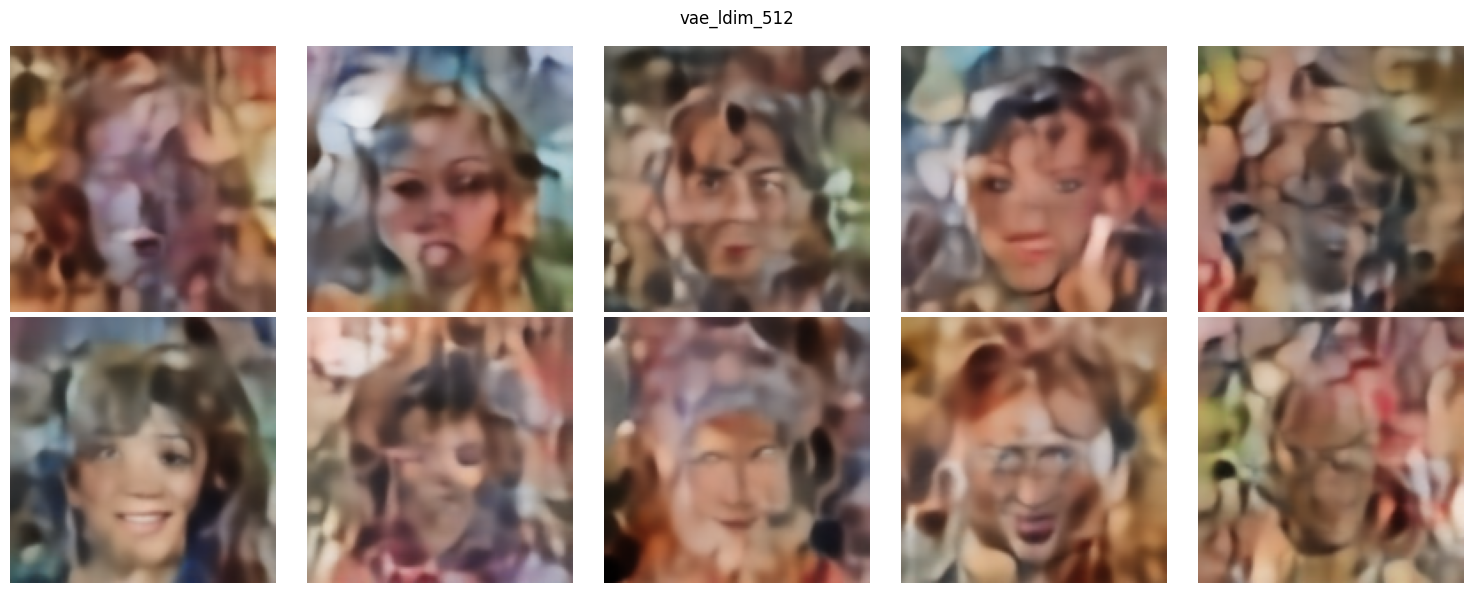

In [7]:
import torch
model = "vae_ldim_512"
model_path = f"checkpoints/{model}_e15.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
m1 = torch.load(model_path, map_location=device)
m1.device = device # this changes the device in the model class
m1.to(device).eval() # this moves weights 

samples, lls = m1.sample(10, current_device = device)
samples = [x.detach().numpy().transpose(1, 2, 0) for x in samples]
plot_images(samples)

In [33]:
import torch

mu = torch.tensor([
    [0.0, 0.2, -0.1],
    [0.5, 0.0, 0.3],
    [-0.4, 0.2, 0.1],
    [0.3, -0.5, 0.0]
])

log_var = torch.tensor([
    [0.0, 0.0, 0.0],
    [0.1, -0.1, 0.2],
    [-0.2, 0.2, -0.1],
    [0.0, 0.0, 0.0]
])

kld_old = -0.5 * torch.mean(1 + log_var - mu**2 - torch.exp(log_var))
print("Current KLD Loss:", kld_old.item())  

# From https://github.com/AntixK/PyTorch-VAE/blob/master/models/beta_vae.py
kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0).item()
print("\nAdding dim=1 to torch.mean, from PyTorchVAE:\nLoss:", kld_loss)

kld_per_sample = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)
kld_new = kld_per_sample.mean()

print("\nExplicit Summing Across Latent Dim, then Average Across Batch:\nLoss:", kld_new.item()) 

Current KLD Loss: 0.042349252849817276

Adding dim=1 to torch.mean, from PyTorchVAE:
Loss: 0.12704776227474213

Explicit Summing Across Latent Dim, then Average Across Batch:
Loss: 0.12704776227474213


In [40]:
import torch
from torch.nn import functional as F

def compute_losses(mu, log_var, recons, inp, bsize):
    # What we're doing now: avg over all elements
    kld_mean_all = -0.5 * torch.mean(1 + log_var - mu**2 - torch.exp(log_var))

    # From PyTorchVAE: sum over latent (dim 1), avg over batches (dim 0)
    kld_mean_dim = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
    

    # Explicit: sum over latent dim, mean over batch
    kld_correct = -0.5 * torch.mean(torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))

    #Reconstruction Loss 
    
    recons_loss = F.mse_loss(recons.view(bsize, -1), inp.view(bsize, -1))
    #recons_loss = torch.nn.functional.mse_loss(recons, inp)
    
    return recons_loss, kld_mean_all.item(), kld_mean_dim.item(), kld_correct.item()


def run_test(batch_size, dims, MN): 

    print(f"\n\n------------------ Using Batch Size = {batch_size} -------------------\n")
    print(f"{'Latent Dim':<12} | {'Rec Loss':>8} | {'KLD Mean() (scaled)':>10} | {'KLD Mean(dim=1) (scaled)':>13}")
    print("-" * 90)
    input_dim = 3 * 150 * 150  
    for dim in dims:
        # generate some examples
        mu = torch.randn(batch_size, dim)
        log_var = torch.randn(batch_size, dim)

        inp = torch.randn(batch_size, input_dim)
        recons = inp + 0.01 * torch.randn_like(inp)  # Small reconstruction noise

        # compute metrics
        r, k1, k2, k3 = compute_losses(mu, log_var, recons, inp, batch_size)
        k1_adjusted = MN*k1
        k2_adjusted = MN*k2
        print(f"{dim:<12} | {r:8.5f} | {k1:10.5f} ({k1_adjusted:.5f}) | {k2:17.5f} ({k2_adjusted:.5f})")

    
# Run test
dims = [2, 8, 32, 128, 512, 1024, 2048]
MN =0.00025
run_test(batch_size = 8, dims =dims, MN=MN)
run_test(batch_size = 64, dims = dims, MN=MN)



------------------ Using Batch Size = 8 -------------------

Latent Dim   | Rec Loss | KLD Mean() (scaled) | KLD Mean(dim=1) (scaled)
------------------------------------------------------------------------------------------
2            |  0.00010 |    0.75594 (0.00019) |           1.51188 (0.00038)
8            |  0.00010 |    0.93471 (0.00023) |           7.47768 (0.00187)
32           |  0.00010 |    0.82244 (0.00021) |          26.31804 (0.00658)
128          |  0.00010 |    0.88309 (0.00022) |         113.03556 (0.02826)
512          |  0.00010 |    0.80907 (0.00020) |         414.24561 (0.10356)
1024         |  0.00010 |    0.81792 (0.00020) |         837.54633 (0.20939)
2048         |  0.00010 |    0.81178 (0.00020) |        1662.53491 (0.41563)


------------------ Using Batch Size = 64 -------------------

Latent Dim   | Rec Loss | KLD Mean() (scaled) | KLD Mean(dim=1) (scaled)
------------------------------------------------------------------------------------------
2     

In [37]:
import torch

# Create a fake tensor: shape (2, 3, 4)
x = torch.arange(2 * 3 * 4).float().reshape(2, 3, 4)
print("Original Tensor x:\n", x)

# 1. Mean over all elements
mean_all = torch.mean(x)
print("\nCalling mean(x) with no dimensions:", mean_all.item())
print("\nCalling flatten().mean():", x.flatten().mean().item())

Original Tensor x:
 tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]],

        [[12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20., 21., 22., 23.]]])

Calling mean(x) with no dimensions: 11.5

Calling flatten().mean(): 11.5


In [10]:
import torch
from torch.nn import functional as F

batch_size =8
dim =64
input_dim =  3 * 150 * 150  
mu = torch.randn(batch_size, dim)
log_var = torch.randn(batch_size, dim)

inp = torch.randn(batch_size, input_dim)
recons = inp + 0.01 * torch.randn_like(inp)  # Small reconstruction noise

recons_loss1 = F.mse_loss(recons, inp)
recons_loss2 = F.mse_loss(recons, inp, reduction='sum') / batch_size
recons_loss3 = F.mse_loss(recons.view(batch_size, -1), inp.view(batch_size, -1))
print("Reconstruction Losses")
print(recons_loss1, recons_loss2, recons_loss3)

kld_loss1 =  -0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp()) / batch_size
kld_loss2 =  -0.5* torch.mean(torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
print("\nKLD Losses")
print(kld_loss1, kld_loss2)


Reconstruction Losses
tensor(9.9982e-05) tensor(6.7488) tensor(9.9982e-05)

KLD Losses
tensor(47.6920) tensor(47.6920)


In [1]:
!which python

/ext3/miniforge3/envs/test/bin/python
